### CAP 6640 
### Script Assignment 2
### Feb 15, 2024

### Group 4
### Andres Graterol
###                   UCF ID: 4031393
### Zachary Lyons
###                   UCF ID: 4226832
### Christopher Hinkle
###                   UCF ID: 4038573
### Nicolas Leocadio
###                   UCF ID: 3791733

We start by reading our corpus data, which is a list of tech news articles found from kaggle

https://www.kaggle.com/datasets/jeet2016/us-financial-news-articles

There is a requirements.txt file with all the needed python modules, "pip install -r requirements.txt"

Old: Prior to running, download corpus from top right of link and then extract to a folder called "archive" in the same directory as this file
New: Extract archive.zip (it's 1.89GB) to ./archive_usfinancial


------------- ./ScriptAssignment2.ipynb

------------- ./archive_usfinancial/*

In [53]:
import os
import json
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

nltk.download('punkt')  # one time execution if not cached yet
nltk.download('stopwords')  # one time execution if not cached yet

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Data Collection & Information Extraction

In [54]:
def read_data(archives_dir):
    corpus = []
    counter = 0
    # os.walk gets all the folders and paths in given directory
    for root, dirs, files in os.walk(archives_dir):
        for i, file in enumerate(files):
            # join path(root) and filename so that this can be computer-independent as long as names are the same
            # open in readonly mode, need encoding and ignore errors for weird characters in docs
            with open(os.path.join(root, file), 'r', encoding="utf8", errors='ignore') as f:
                # load json, can use strings for index from json tree
                # if data you want is inside of some structure, can use index like ['test1']['title']
                # https://devqa.io/python-parse-json/
                
                data = json.load(f)
                appendme = data['title'] + " " + data['published'] + " " + data['text'] # Create string with title, publish date, and document text
                
                if appendme: # Make sure not empty string
                    corpus.append((appendme))
            
            # This is here to only go through a few documents instead of the 2GB of documents
            # Leave in place to speed up testing/debug
            # Uncomment for real data/tests
            counter += 1
            if counter > 99: # Break because a lot of documents
                return corpus
            
# Extracted the articles into folder called "archive_usfinancial", change as needed
# read_data() will parse through all folders/files inside there

######################################################
########### WARNING: There are a lot of files in there and it took an hour and a half to extract on my desktop
######################################################
corpus = read_data(os.getcwd() + "\\archive_usfinancial")

In [55]:
def tokenize(corpus):
    regex = re.compile('[^a-zA-Z0-9]')  # regex to only match alphanumeric characters
    tokens = []
    
    for sent in nltk.sent_tokenize(corpus):
        for word in nltk.word_tokenize(sent):
            clean_word = regex.sub('', word)
            if clean_word:  # make sure we're not appending empty strings
                tokens.append(clean_word.lower())
    return tokens

tokens = tokenize(corpus[0])
tokens[50:60]

['the',
 'emerging',
 'market',
 'etf',
 'eem',
 'was',
 'a',
 'weak',
 'dollar',
 'and']

In [56]:
def remove_stopwords(tokens):
    stopwords = nltk.corpus.stopwords.words('english')
    return [word for word in tokens if word not in stopwords]

no_stopwords = remove_stopwords(tokens)
no_stopwords[50:60]

['charts',
 'dollartracking',
 'etf',
 'uup',
 'believes',
 'us',
 'currency',
 'continue',
 'help',
 'group']

In [57]:
stemmer = SnowballStemmer("english")

def stem_words(word):
    return stemmer.stem(word).strip()

stemmed = [stem_words(word) for word in no_stopwords]
stemmed[50:60]

['chart',
 'dollartrack',
 'etf',
 'uup',
 'believ',
 'us',
 'currenc',
 'continu',
 'help',
 'group']

#### Topic Modeling

In [8]:
# @TODO: Re-do the tfid vectorizer with the preprocessing as a single function
# @TODO: Maybe it's not needed though
# @TODO: same todo as below

# from nltk.stem.snowball import SnowballStemmer
# def preprocess_corpus(corpus):
#     # Tokenize
#     regex = re.compile('[^a-zA-Z0-9]')  # regex to only match alphanumeric characters
#     tokens = []
    
#     for sent in nltk.sent_tokenize(corpus):
#         for word in nltk.word_tokenize(sent):
#             clean_word = regex.sub('', word)
#             if clean_word:  # make sure we're not appending empty strings
#                 tokens.append(clean_word.lower())

#     print(tokens[50:60]) # Print for debug
    
#     # Remove stopwords
#     stopwords = nltk.corpus.stopwords.words('english')
#     no_stopwords = [word for word in tokens if word not in stopwords]

#     print(no_stopwords[50:60]) # Print for debug

#     # Stemming
#     stemmer = SnowballStemmer("english")

#     stemmed = [stemmer.stem(word).strip()for word in no_stopwords]
#     print(stemmed[50:60]) # Print for debug
        
#     return stemmed
     
# processed_data = preprocess_corpus(corpus[0])

In [58]:
tfidf = TfidfVectorizer(max_df=0.95, max_features=50000,
                        min_df=0.0, stop_words='english',
                        use_idf=True, tokenizer=tokenize,
                        preprocessor=stem_words, lowercase=True)

tfidf_matrix = tfidf.fit_transform(corpus)

C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', '

In [59]:
# @TODO: Re-do the tfid vectorizer with the preprocessing as a single function
# @TODO: Maybe it's not needed though

# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf2 = TfidfVectorizer(max_df=0.8, max_features=200000,
#                         min_df=0.05, stop_words='english',
#                         use_idf=True,
#                         preprocessor=preprocess_corpus, lowercase=True)
# tfidf_matrix2 = tfidf2.fit_transform(corpus)

In [60]:
# @TODO: Need to reformat and comment/write this better for readability and understanding
# @TODO: Also need to figure out what kind of results/metrics we can get out of this and report

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

for i,topic in enumerate(lda.components_):
    print(f'Topic #{i}:')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

Topic #0:
['auto', 'johnson', 'bitcoin', 'china', 'wechat', 'tax', 'products', 'macy', 'euro', 's']


Topic #1:
['new', '2017', 'exits', 'korea', 'said', 'bitcoin', 'percent', 'year', 'billion', 's']


Topic #2:
['ripple', 'tax', 'said', 'ago', '0054', 'market', 'cramer', 's', '2018', 'percent']


Topic #3:
['netflix', 'said', 'company', 'hatch', 'peso', '1', 'caterpillar', 'cousins', 'compass', 's']


Topic #4:
['sales', 'intel', 'vehicles', 'apple', 'google', 'cramer', 'china', 'amazon', 'said', 's']




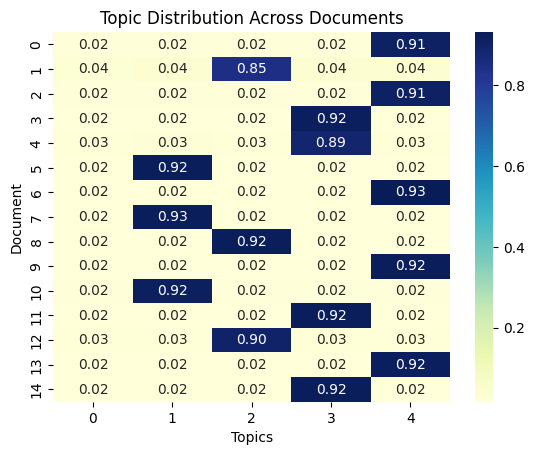

Topic Counts:  Counter({1: 26, 4: 21, 2: 21, 3: 19, 0: 13})


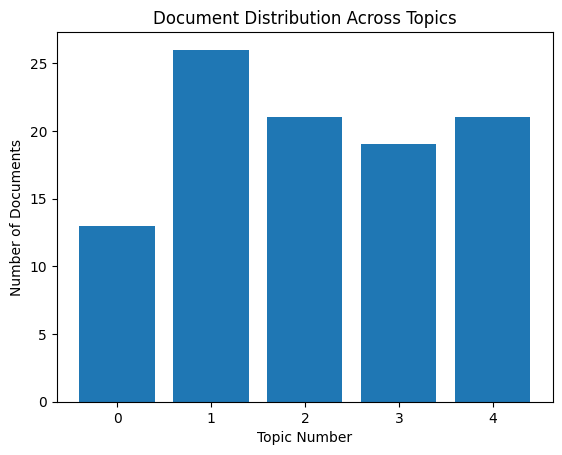

In [70]:
'''
    Returns a heat map showing the distribution of topics across n documents
'''
def topic_heat_map(topic_values, n):
    subset_values = topic_values[:n]

    sns.heatmap(subset_values, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.xlabel('Topics')
    plt.ylabel('Document')
    plt.title('Topic Distribution Across Documents')
    plt.show()

'''
    Returns a bar plot showing the distribution of documents across topics
'''
def topic_bar_plot(document_topics):
    # Obtain a dictionary that tells us in how many documents a topic was found in
    topic_counts = Counter(document_topics)
    print("Topic Counts: ", topic_counts)

    topics = topic_counts.keys()
    num_documents = topic_counts.values()

    plt.bar(topics, num_documents)
    plt.xlabel('Topic Number')
    plt.ylabel('Number of Documents')
    plt.title('Document Distribution Across Topics')
    plt.show()

topic_values = lda.transform(tfidf_matrix)  
n_documents = 15 # Determine how many documents we want to display the heatmap for 
topic_heat_map(topic_values, n_documents)

document_topics = topic_values.argmax(axis=1) # Get the most well-represented topic for each document
topic_bar_plot(document_topics)